# Part 0: Learning Objectives and Setup

## What you will learn
- Neural data preprocessing
 - - Binning
 - - Smoothing
 - - Aligning
- Basic neural network training pipelines
- - Poisson Loss
- - Training Loops
- - Evaluation Metrics
- Autoencoders (AEs) applied to neural data 
- - Behavioral decoding
- Basic flavors of Recurrent Neural Network (RNN)
- - Linear
- - Nonlinear
- - GRU
- Sequential Autoencoders (SAEs)
- Variational Autoencoders(VAEs)

## Environment setup


Run this code to prepare the environment for this demonstration

In [297]:
## TODO: Run this once to set up your environment. Comment these out if you have to restart your notebook for speed.
!pip3 install torch
!pip3 install pytorch_lightning
!pip3 install torchvision
!pip3 install dandi
!pip3 install git+https://github.com/neurallatents/nlb_tools.git
!pip3 install cmasher

  Using cached dandi-0.40.1-py3-none-any.whl (322 kB)
  Using cached click_didyoumean-0.3.0-py3-none-any.whl (2.7 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached interleave-0.2.0-py3-none-any.whl (11 kB)
  Using cached dandischema-0.7.1-py3-none-any.whl (63 kB)
  Using cached pyout-0.7.2-py3-none-any.whl (51 kB)
  Using cached etelemetry-0.3.0-py3-none-any.whl (6.3 kB)
  Using cached fscacher-0.2.0-py3-none-any.whl (11 kB)
  Using cached fasteners-0.17.3-py3-none-any.whl (18 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached keyrings.alt-4.1.0-py3-none-any.whl (20 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached nwbinspector-0.4.5-py3-none-any.whl (31 kB)
  Using cached keyring-23.6.0-py3-none-any.whl (34 kB)
  Using cached ci_info-0.2.0-py3-none-any.whl (6.9 kB)
  Using cached natsort-8.1.0-py3-none-any.whl (37 kB)
  Using cached numpy-1.21.6-c

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Chris\\AppData\\Local\\Temp\\pip-uninstall-cxulzkjo\\core\\_multiarray_tests.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## Data download

Uncomment the line below to download the dataset into your colab notebook. We'll be using the dataset collected by Mark Churchland and first published in 2008 called the "Maze Dataset". It is publically available as part of the Neural Latents Benchmark contest (https://neurallatents.github.io/).

In [296]:
## This downloads the dataset that we will be using for this workshop
## Only needs to be run once
# !dandi download DANDI:000140/0.220113.0408

'dandi' is not recognized as an internal or external command,
operable program or batch file.


## Imports and helper functions

Run this section once to get useful helper functions and imports. You shouldn't need to modify any of this code

In [298]:
## Generic imports and helper functions that we will use later in the notebook. Put here to reduce clutter.
# Imports
import os
import torch
from torchvision import datasets
from torchvision import transforms

from sklearn.linear_model import LinearRegression
from nlb_tools.nwb_interface import NWBDataset
import h5py
import numpy as np
import logging
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import cmasher as cmr
logger = logging.getLogger(__name__)
from sklearn.decomposition import PCA
from torch.autograd import Variable

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

import random
' Tensor saving functions '''
random.seed(2022)

def _check_h5_r(data_dict, h5obj, overwrite):
    """Recursive helper function that finds duplicate keys and deletes them if `overwrite == True`
    
    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    h5obj : h5py.File or h5py.Group
        h5py object to check for duplicates
    overwrite : bool, optional
        Whether to overwrite duplicate data found 
        at `save_path` if file already exists, by
        default False
    
    Returns
    -------
    tuple
        Tuple containing bool of whether `h5obj` passes
        checks and list of duplicate keys found
    """
    dup_list = []
    good = True
    for key in data_dict.keys():
        if key in h5obj.keys():
            if isinstance(h5obj[key], h5py.Group) and isinstance(data_dict[key], dict):
                rgood, rdup_list = _check_h5_r(data_dict[key], h5obj[key], overwrite)
                good = good and rgood
                dup_list += list(zip([key] * len(rdup_list), rdup_list))
            else:
                dup_list.append(key)
                if overwrite:
                    del h5obj[key]
                else:
                    good = False
    return good, dup_list

def save_to_h5(data_dict, save_path, overwrite=False, dlen=32):
    """Function that saves dict as .h5 file while preserving
    nested dict structure

    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    save_path : str
        Path to location where data should be saved
    overwrite : bool, optional
        Whether to overwrite duplicate data found 
        at `save_path` if file already exists, by
        default False
    dlen : int, optional
        Byte length of data format to save numerical data,
        by default 32.
    """
    h5file = h5py.File(save_path, 'a')
    good, dup_list = _check_h5_r(data_dict, h5file, overwrite)
    if good:
        if len(dup_list) > 0:
            logger.warning(f"{dup_list} already found in {save_path}. Overwriting...")
        _save_h5_r(data_dict, h5file, dlen)
        logger.info(f"Saved data to {save_path}")
    else:
        logger.warning(f"{dup_list} already found in {save_path}. Save to file canceled. " \
            "Please set `overwrite=True` or specify a different file path.")
    h5file.close()

    
def _save_h5_r(data_dict, h5obj, dlen):
    """Recursive function that adds all the items in a dict to an h5py.File or h5py.Group object

    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    h5obj : h5py.File or h5py.Group
        h5py object to save data to
    dlen : int, optional
        Byte length of data format to save numerical data,
        by default 32.
    """
    for key, val in data_dict.items():
        if isinstance(val, dict):
            h5group = h5obj[key] if key in h5obj.keys() else h5obj.create_group(key)
            _save_h5_r(val, h5group, dlen)
        else:
            if val.dtype == 'object':
                sub_dtype = f'float{dlen}' if val[0].dtype == np.float else f'int{dlen}' if val[0].dtype == np.int else val[0].dtype
                dtype = h5py.vlen_dtype(sub_dtype)
            else:
                dtype = f'float{dlen}' if val.dtype == np.float else f'int{dlen}' if val.dtype == np.int else val.dtype
            h5obj.create_dataset(key, data=val, dtype=dtype)
            
def to_tensor(array):
    """Converts a loaded numpy array to a tensor
    and ensures correct dtype

    Parameters
    ----------
    array : np.array
        The numpy array to convert.

    Returns
    -------
    torch.Tensor
        The converted tensor.
    """
    return torch.tensor(array, dtype=torch.float)
        
def _prep_fp(make_params, fp_steps, bin_width_ms):
    """Helper function that makes separate make_params
    for forward prediction data

    Parameters
    ----------
    make_params : dict
        Arguments for `NWBDataset.make_trial_data`
        to extract trialized data
    fp_steps : int
        Amount of time for which forward prediction
        spiking activity is extracted, in ms
    bin_width_ms : int
        Dataset bin width in ms
    
    Returns
    -------
    dict
        Arguments for `NWBDataset.make_trial_data`
        to extract trialized forward prediction data
    """
    align_point = make_params.get('align_field', make_params.get('end_field', 'end_time'))
    align_start = make_params.get('align_range', (0,0))[1]
    align_window = (align_start, align_start + fp_steps * bin_width_ms)
    fp_make_params = {
        'align_field': align_point,
        'align_range': align_window,
        'allow_overlap': True,
    }
    return fp_make_params

# Part 1: Neural Dynamics and Maze Data

## Overview of Maze Dataset

This dataset was collected from primary motor cortex (M1) and dorsal premotor cortex (PMd). A basic description can be found in the blurb on the NLB datasets page: https://neurallatents.github.io/datasets

    The maze task is a delayed center-out reach task with barriers, resulting in a variety of straight and curved trajectories. Neural activity was recorded from the dorsal premotor and primary motor cortices, and cursor, monkey gaze position, and monkey hand position and velocity are also provided.

    It has been found that M1/PMd activity during such planned, highly-stereotyped movements is predictable from neural population state at movement onset. Though this does not imply the neural system is itself autonomous, predictability makes the dataset useful for evaluating a method’s ability to model autonomous dynamics. In addition to a standard session, we provide 3 recording sessions (standard, large, medium, and small) with varying numbers of trials in order to test how modeling methods scale to limited data.

    The 4 recording sessions we are releasing are provided by Matt Kaufman, Mark Churchland, and Krishna Shenoy at Stanford University.
We will be using the "small" version for ease of computational resources

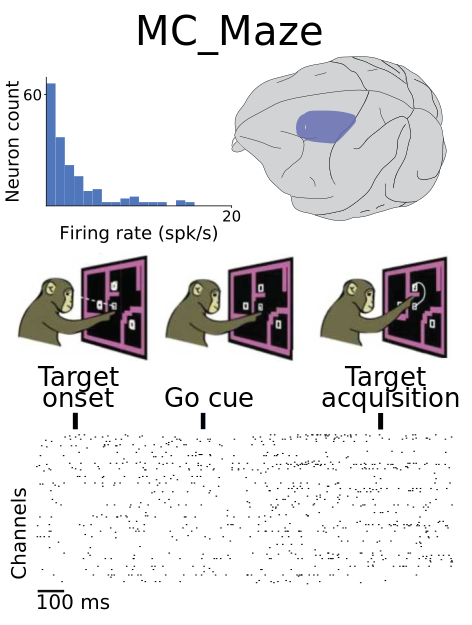

In [392]:
from IPython import display
display.Image("./maze_fig1.png")

First things first: We want to deal with the data in a manageable bin size: Currently it is binned a 1 ms bin widths, which means that the vast majority of bins have no spikes in them. We're going to move to a larger bin size (5 ms) for convenience

In [393]:
## Get the current path and pull the dataset into the Neurodata Without Borders format
curr_path = os.getcwd()
fpath = curr_path + '/000140/sub-Jenkins/'
os.listdir(fpath) 

dataset = NWBDataset(fpath=fpath) 

## Resample the dataset to 20 ms bin size
print(f'Data shape: {dataset.data.shape}')
print(f'Bin width: {dataset.bin_width} ms')
dataset.resample(5)
print(f'Resampled data shape: {dataset.data.shape}')
print(f'Resampled bin width: {dataset.bin_width} ms')

c:\Users\Chris\miniconda3\envs\chenEnv\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Data shape: (373666, 150)
Bin width: 1 ms
Resampled data shape: (74734, 150)
Resampled bin width: 5 ms


## Inspect Maze dataset
Now we're going to look at the dataset and see what it's components are. We'll start with one field, the "trial_info"

In [397]:
## Inspect the fields available to you

print(dataset.trial_info)
dataset.trial_info["split"]

     trial_id             start_time               end_time  \
0           0        0 days 00:00:00 0 days 00:00:00.700000   
1           1 0 days 00:00:00.800000 0 days 00:00:01.500000   
2           2 0 days 00:00:01.600000 0 days 00:00:02.300000   
3           3 0 days 00:00:02.400000 0 days 00:00:03.100000   
4           4 0 days 00:00:03.200000 0 days 00:00:03.900000   
..        ...                    ...                    ...   
195       195 0 days 00:05:58.600000 0 days 00:06:02.021000   
196       196 0 days 00:06:02.100000 0 days 00:06:04.466000   
197       197 0 days 00:06:04.500000 0 days 00:06:07.376000   
198       198 0 days 00:06:07.400000 0 days 00:06:10.736000   
199       199 0 days 00:06:10.800000 0 days 00:06:13.666000   

           move_onset_time  split  trial_type  trial_version  maze_id success  \
0   0 days 00:00:00.250000   test         NaN            NaN      NaN     NaN   
1   0 days 00:00:01.050000   test         NaN            NaN      NaN     NaN   


0       test
1       test
2       test
3       test
4       test
       ...  
195      val
196    train
197      val
198      val
199    train
Name: split, Length: 200, dtype: object

As you can see there is a lot of important info in this structure: In general, each row represents a single trial. Each entry has a start time, end time, movement onset time, what type of trial it is, etc. Importantly, this dataset has the train/val/test split done for us already, so we will use these flags in our training

A second important field is the data itself:

In [127]:
dataset.data

signal_type             cursor_pos                eye_pos              \
channel                          x          y           x           y   
clock_time                                                              
0 days 00:00:00                NaN        NaN         NaN         NaN   
0 days 00:00:00.020000         NaN        NaN         NaN         NaN   
0 days 00:00:00.040000         NaN        NaN         NaN         NaN   
0 days 00:00:00.060000         NaN        NaN         NaN         NaN   
0 days 00:00:00.080000         NaN        NaN         NaN         NaN   
...                            ...        ...         ...         ...   
0 days 00:06:13.580000 -114.950080 -78.179086 -129.071311 -124.779909   
0 days 00:06:13.600000 -118.719574 -80.796429 -131.380982 -126.364288   
0 days 00:06:13.620000 -112.923007 -76.621959 -125.184554 -119.938158   
0 days 00:06:13.640000 -123.281313 -83.647240 -137.345761 -131.580521   
0 days 00:06:13.660000  -88.921673 -60.366399  -99.181082  -94.736532   

signal_type               hand_pos              hand_vel             \
channel                          x           y         x          y   
clock_time                                                            
0 days 00:00:00                NaN         NaN       NaN        NaN   
0 days 00:00:00.020000         NaN         NaN       NaN        NaN   
0 days 00:00:00.040000         NaN         NaN       NaN        NaN   
0 days 00:00:00.060000         NaN         NaN       NaN        NaN   
0 days 00:00:00.080000         NaN         NaN       NaN        NaN   
...                            ...         ...       ...        ...   
0 days 00:06:13.580000 -114.978105 -112.799547  0.892179  -0.334572   
0 days 00:06:13.600000 -118.739626 -116.364960 -0.650591  11.038076   
0 days 00:06:13.620000 -112.942811 -110.570069  1.332894  -1.097608   
0 days 00:06:13.640000 -123.282262 -120.727077  0.051641   4.226674   
0 days 00:06:13.660000  -88.990101  -87.011763 -2.415841   7.045104   

signal_type            heldout_spikes       ... spikes                      \
channel                          1012 1021  ...   2771 2772 2791 2792 2801   
clock_time                                  ...                              
0 days 00:00:00                   NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.020000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.040000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.060000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.080000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
...                               ...  ...  ...    ...  ...  ...  ...  ...   
0 days 00:06:13.580000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.600000            0.0  0.0  ...    1.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.620000            0.0  0.0  ...    0.0  0.0  0.0  1.0  0.0   
0 days 00:06:13.640000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.660000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   

signal_type                                      
channel                2802 2812 2821 2842 2861  
clock_time                                       
0 days 00:00:00         0.0  0.0  1.0  0.0  0.0  
0 days 00:00:00.020000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.040000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.060000  0.0  0.0  1.0  0.0  0.0  
0 days 00:00:00.080000  2.0  0.0  0.0  0.0  0.0  
...                     ...  ...  ...  ...  ...  
0 days 00:06:13.580000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.600000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.620000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.640000  1.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.660000  0.0  0.0  0.0  0.0  0.0  

[18684 rows x 150 columns]

Looking at the data, we can see that there are cursor and eye positions, hand positions and velocities, and spikes.
Importantly, there are "heldout_spikes" and "spikes". To explain what this means, take a look at the figure below.

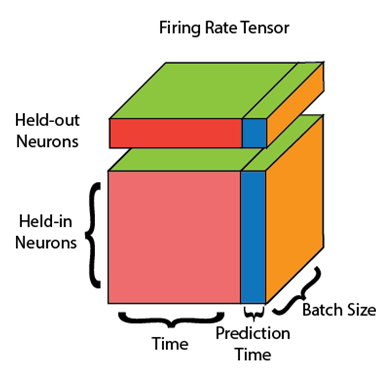

In [398]:
from IPython import display
display.Image("./FRTensor.png")

A major goal for our model of neural data is to be able to capture features of the data that were not explicitly trained. 
For this reason we 
1. Hold out some neurons
2. Don't show the model the whole trial.

If our model can successfully model the neurons that it doesn't see at the input and at unseen times, then we have some assurance that it's doing something useful
The red rectangle above represents the neurons that we will be leaving out from our models, while the blue rectangle are "forward predictions". We will discuss what these mean a bit later

Now, we want to work with these data in a "trialized" format, where all the data for each trial is grouped together.
We will use a function from the NLB tools "make_trial_data", which takes in a flag as to which landmark in the trial
to align to, and a range around which to align. Move onset - 250 to move onset  + 450 will be the defaults, but feel free to play around with them

In [412]:
trial_data = dataset.make_trial_data(align_field = "move_onset_time", align_range = (-250, 450))
print(trial_data.trial_id)

NaNs found in `self.data`. Dropping 50.00% of points to remove NaNs from `trial_data`.


14000    100
14001    100
14002    100
14003    100
14004    100
        ... 
27995    199
27996    199
27997    199
27998    199
27999    199
Name: trial_id, Length: 14000, dtype: int32


As you can see, each row of the trial_data structure has a "trial_id" field, which we can use to segregate out trials more easily for future analysis.
For now, we want to visualize what these data look like. For that, we will need to spin up a basic smoothing function. Complete the code below, then run this section!

NaNs found in `self.data`. Dropping 50.00% of points to remove NaNs from `trial_data`.


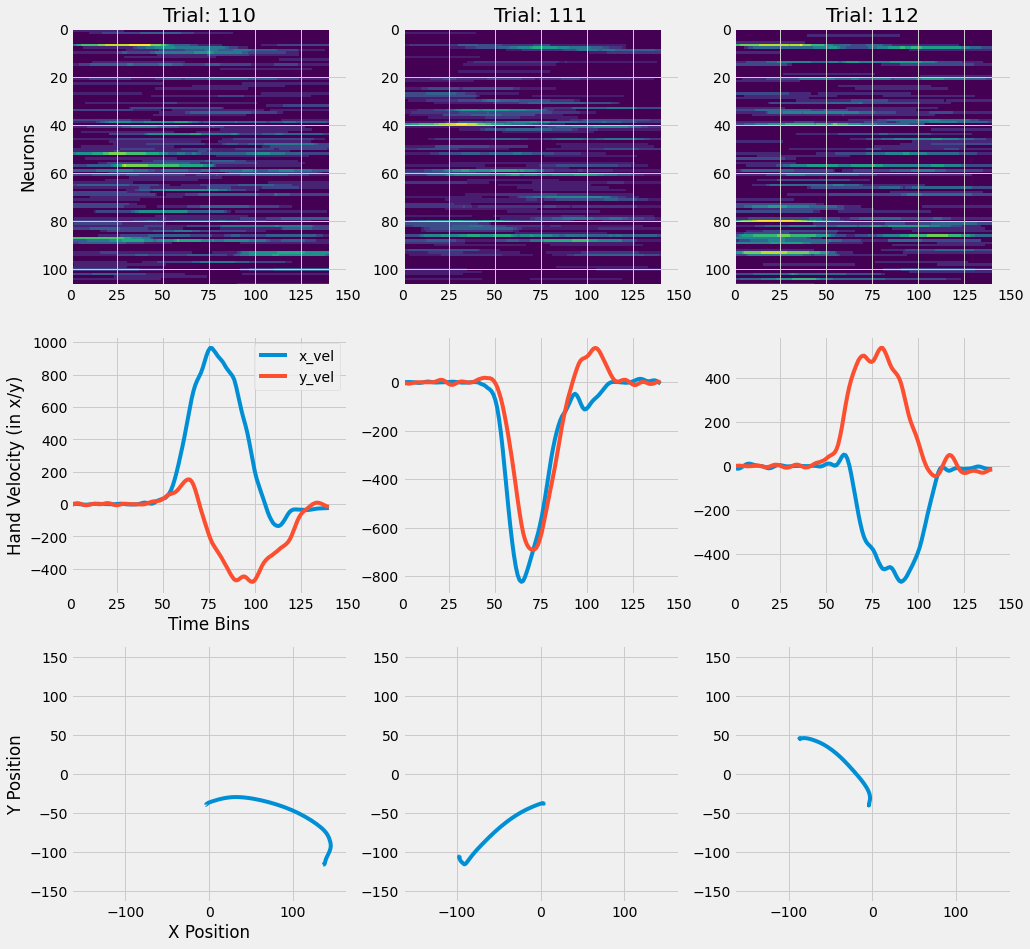

In [406]:
# Visualize smoothed firing rates
def smoothFiring(data, kernel_size):
    ## TODO: Run a moving-average smoothing filter over the firing rates
    ## Hint: See np.convolve
    if kernel_size > 1:
    #-----------For Students--------------------
        
    #-------------------------------------------
    return data


def plot_trials(trial_data, kernel_size, trial_nums):
    fig, axes = plt.subplots(3, len(trial_nums),  figsize = (5*len(trial_nums),15))
    for i, trial_ind in enumerate(trial_nums):
        trial = trial_data[trial_data['trial_id'] == trial_ind]
        firing = trial["spikes"][:].to_numpy()
        firing_smooth = smoothFiring(firing, kernel_size)
        ax1 = axes[0][i]
        ax1.imshow(firing_smooth.T,interpolation='nearest', aspect='auto')
        t = np.linspace(0,len(firing_smooth[:,1]), len(firing_smooth[:,1]))
        if i == 0:
            ax1.set_ylabel('Neurons')
        ax1.set_title(f"Trial: {trial_ind}")
        ax1.set_xlim((0, 150))
        ax2 = axes[1][i]
        ax2.plot(t,trial["hand_vel"]["x"], label = "x_vel")
        ax2.plot(t,trial["hand_vel"]["y"], label = "y_vel")
        ax2.set_xlim(0, 150)
        if i == 0:
            ax2.set_xlabel('Time Bins')
            ax2.set_ylabel("Hand Velocity (in x/y)")
            ax2.legend()

        ax3 = axes[2][i]
        ax3.plot(trial["hand_pos"]["x"], trial["hand_pos"]["y"])
        ax3.set_xlim((-165, 165))
        ax3.set_ylim((-165, 165))
        if i == 0:
            ax3.set_xlabel('X Position')
            ax3.set_ylabel("Y Position")

# Play around and plot a few different trials to see how the behavior looks
trials_to_plot = [110, 111,112]
kernel_size = 50

plot_trials(trial_data, kernel_size = kernel_size, trial_nums = trials_to_plot)

Take 10 minutes or so to dig around the trial_data structure to figure out how it works.

## Trim and package data for training
Now we are going to make our dataloaders for PyTorch.
We will make four dataloaders in total. Each dataloader will return three fields
- heldin spikin, 
- reconstructed spiking 
- hand velocities (for comparing model performance)

Two dataloaders will be "training" data and two will be "validation" data

Two dataloaders should return spiking activity that is "stacked" across trials (i.e., a 2D array of dimension (BxT) x N, where B is the number of trials, T is the trial length, and N is the number of neurons), while the other two dataloaders should return the 3D spiking tensor (BxTxN).

These array and tensor dataloaders will be relevant for the autoencoder and sequential autoencoders respectively.

Given the requirements above, complete the missing code.

In [303]:
def make_array_dataloader(dataset, spk_field, hospk_field, align_field, align_window,
                    trial_split):

    split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
    trial_mask = split_to_mask(trial_split)
    allow_nans = trial_split != "train"
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field, align_range = align_window)

    # ---------------------For students -----------------------------------

    # --------------------------------------------------------------------------

    print(f"Shape of heldin array {heldin.shape}.")
    print(f"Shape of heldout array {heldout.shape}.")
    print(f"Shape of vel {vel.shape}.")

    recon_data = torch.cat([heldin, heldout], dim =1)

    tensors = [heldin, recon_data, vel]
    array_dataset = TensorDataset(heldin, recon_data, vel)


    dataloader = DataLoader(array_dataset,
                                batch_size = 200,
                                num_workers = 4,
                                shuffle = True)
    return dataloader, tensors

def make_tensor_dataloader(dataset, spk_field, hospk_field, align_field, align_window,
                    trial_split, align_field_fwd, align_window_fwd):

    split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
    trial_mask = split_to_mask(trial_split)
    allow_nans = trial_split != "train"
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field, align_range = align_window)
    trial_data_fwd = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field_fwd, align_range = align_window_fwd)

    grouped = list(trial_data.groupby('trial_id', sort=False))
    grouped_fwd = list(trial_data_fwd.groupby('trial_id', sort=False))

    # ---------------------For students -----------------------------------

    # --------------------------------------------------------------------------

    print(f"Shape of heldin array {heldin.shape}.")
    print(f"Shape of heldout array {heldout.shape}.")
    print(f"Shape of heldin array fwd {heldin_fwd.shape}.")
    print(f"Shape of heldout array fwd {heldout_fwd.shape}.")

    heldin_full = torch.cat([heldin, heldin_fwd], dim=1)
    heldout_full = torch.cat([heldout, heldout_fwd], dim = 1)
    recon_data = torch.cat([heldin_full, heldout_full], dim =2)

    tensors = [heldin, recon_data, vel]
    tensor_dataset = TensorDataset(heldin, recon_data, vel)
    dataloader = DataLoader(tensor_dataset,
                                    batch_size = 25,
                                    num_workers = 4,
                                    shuffle = False)


    
    return dataloader, tensors

dl_array_train, ds_array_train = make_array_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    trial_split= "train")

dl_array_eval, ds_array_eval =  make_array_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    trial_split= "val")


dl_tensor_train, ds_tensor_train = make_tensor_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    align_field_fwd= "move_onset_time", align_window_fwd= (450,650),
                                    trial_split= "train")
dl_tensor_eval, dl_tensor_eval = make_tensor_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    align_field_fwd= "move_onset_time", align_window_fwd= (450,650),
                                    trial_split= "val")



Shape of heldin array torch.Size([2625, 107]).
Shape of heldout array torch.Size([2625, 35]).
Shape of vel torch.Size([2625, 2]).
Shape of heldin array torch.Size([875, 107]).
Shape of heldout array torch.Size([875, 35]).
Shape of vel torch.Size([875, 2]).
Shape of heldin array torch.Size([75, 35, 107]).
Shape of heldout array torch.Size([75, 35, 35]).
Shape of heldin array fwd torch.Size([75, 10, 107]).
Shape of heldout array fwd torch.Size([75, 10, 35]).
Shape of heldin array torch.Size([25, 35, 107]).
Shape of heldout array torch.Size([25, 35, 35]).
Shape of heldin array fwd torch.Size([25, 10, 107]).
Shape of heldout array fwd torch.Size([25, 10, 35]).


With these dataloaders, we can begin to model the neural activity!

# Part 2: Vanilla Autoencoder

First things first: what happens if we run the data through a simple nonlinear autoencoder?
You should remember this from last Friday: fill out the missing code.

In [470]:
# Vanilla AE code

class VanillaAE(torch.nn.Module):
  # TODO: Complete the autoencoder model
  # Encoder requirements: 
  #   - ReLU activation functions
  #   - Input size = n_neurons_in
  #   - Hidden layer sizes : 64, 16
  #   - Output size: latent_dim
  # Decoder requirements:
  #   - Input size = latent_dim
  #   - Hidden layer sizes : 16, 64
  #   - Output size: n_neurons_out

    def __init__(self, n_neurons_in, n_neurons_out, latent_dim):
        super().__init__()
          
        self.n_neurons_in = n_neurons_in
        self.n_neurons_out = n_neurons_out
        self.latent_dim = latent_dim
        #----------------For Students-----------------------
        self.encoder = "TODO"
          
        self.decoder = "TODO"
        #----------------------------------------------------

    def forward(self, x):
        # Implement forward pass of AE network. 
        # Be sure to return both the predictions and the latent activity.
        # Remember that the autoencoder itself is predicting the log-rates, so you have to
        # transform it to the correct domain (0,inf)
        #----------------For Students-----------------------
        latents = "TODO"
        rates = "TODO"
        return rates, latents
        #----------------------------------------------------
        

## Prepare to train your autoencoder
Now that you've got an autoencoder model, it's time to train it.
The first thing that we need to do is instantiate our model, our optimizer, and our loss function.

In [427]:
# Build your training loop
latent_dim = 20
#----------------For Students-----------------------
model = "TODO"

loss_function = "TODO"

optimizer = "TODO"
#----------------------------------------------------


Now that we've got the model initialized and the optimizer and loss function chosen, we should be ready to construct our training loop.
We ant to evaluate our model occasionally on the validation dataset, but not use that data to train the model.

Complete the two sections of the code below to allow us to train the model and log the validation loss.

In [428]:
epochs = 40

outputs = []
losses = []
eval_losses = []
for epoch in range(epochs):
  if np.mod(epoch, 2)==0:
    print("Epoch: {}".format(epoch))
    model.eval()
    #------------------For Students------------------------

    #------------------------------------------------------
  for (data_batch, data_recon, vel_ds) in dl_array_train:
    model.train()
    #------------------For Students------------------------
    
    #-----------------------------------------------------
    # Storing the losses in a list for plotting
    losses.append([epoch, loss.detach().numpy()])

      #------------------------------------------------------
  outputs.append((epochs, data_batch, reconstructed))

Epoch: 0
Epoch: 2
Epoch: 4
Epoch: 6
Epoch: 8
Epoch: 10
Epoch: 12
Epoch: 14
Epoch: 16
Epoch: 18
Epoch: 20
Epoch: 22
Epoch: 24
Epoch: 26
Epoch: 28
Epoch: 30
Epoch: 32
Epoch: 34
Epoch: 36
Epoch: 38


## How's the model doing?
Now we can look to see how well the vanilla autoencoder models our data. First we are going to just look at the loss.

How many epochs seem to be sufficient to train this model?

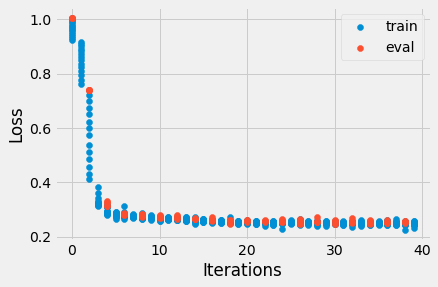

In [429]:
losses_arr = np.array(losses)
eval_losses_arr = np.array(eval_losses)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.scatter(losses_arr[:,0], losses_arr[:,1], label = "train")
plt.scatter(eval_losses_arr[:,0],eval_losses_arr[:,1], label = "eval")
plt.legend()

## Latent trajectories!

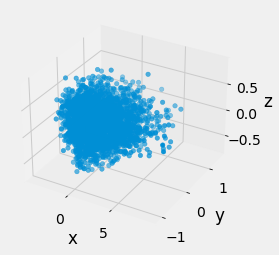

In [462]:
def scatter_latents(latents):
    latents_all = latents.detach().numpy()
    pca = PCA(n_components=3)
    latents = pca.fit_transform(latents_all)

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection="3d")
    ax1.scatter(*latents.T)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
# Plot Latent trajectories

pred_rates, latents = model(ds_array_train[0])

scatter_latents(latents)

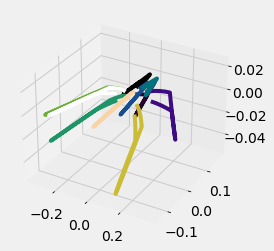

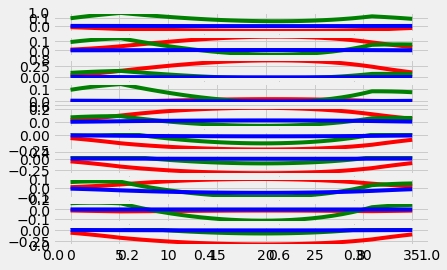

In [463]:
def plot_smoothed_latent_trajs(latents, num_trials, kernel_size):
    cmap = cmr.rainforest
    colors = cmap(np.linspace(0, 1, num_trials))
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection="3d")
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    n_trials, n_steps, n_latents = latents.shape
    pca = PCA(n_components=3)
    latents_flat = latents.reshape(-1, n_latents)
    latents = pca.fit_transform(latents_flat)
    latents = latents.reshape(n_trials, n_steps, 3)
    t = np.linspace(0, n_steps, n_steps)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    latents_smooth = np.zeros_like(latents)
    for i in range(num_trials):
        latents_trial = np.squeeze(latents[i,:,:])
        latents_trial = smoothFiring(latents_trial, kernel_size)
        latents_smooth[i,:,:] = latents_trial
        ax2.plot(latents_trial[:, 0], latents_trial[:,1], latents_trial[:,2], color = colors[i,:])
        ax3 = fig3.add_subplot(num_trials, 1, i+1)
        ax3.plot(t, latents_trial[:,0], color = 'r')
        ax3.plot(t, latents_trial[:,1], color = 'g')
        ax3.plot(t, latents_trial[:,2], color = 'b')
        


num_trials = 10
kernel_size = 10

pred_rates, latents_all = model(ds_tensor_train[0])
pred_rates = pred_rates.detach().numpy()
rates = ds_tensor_train[0].detach().numpy()
latents_all = latents_all.detach().numpy()

n_trials, n_bins, n_latents = latents_all.shape
plot_smoothed_latent_trajs(latents_all, num_trials, kernel_size)


How can we tell that our models are doing well?

Why not try to decode behavior from the de-noised neural activity?

In [471]:
latents_smooth = np.zeros((n_trials, n_bins, n_latents))
rates_smooth = np.zeros((n_trials, n_bins, 107))
pred_rates_smooth = np.zeros((n_trials, n_bins, 142))

kernel_size = 1

for i in range(latents_all.shape[0]):
    latents_smooth[i,:,:] = smoothFiring(np.squeeze(latents_all[i,:,:]), kernel_size)
    rates_smooth[i,:,:] = smoothFiring(np.squeeze(rates[i,:,:]), kernel_size)
    pred_rates_smooth[i,:,:] = smoothFiring(np.squeeze(pred_rates[i,:,:]), kernel_size)

vel = ds_tensor_train[2]
vel = np.reshape(vel, (-1, 2))
latents_fit = latents_smooth.reshape((-1, n_latents))
rates_fit = rates_smooth.reshape((-1, 107))
pred_rates_fit = pred_rates_smooth.reshape((-1, 142))
pred_rates_fit = pred_rates_fit[:,:107]

regX = LinearRegression().fit(latents_fit, vel[:,0])
regY = LinearRegression().fit(latents_fit, vel[:,1])

regRatesX = LinearRegression().fit(rates_fit, vel[:,0])
regRatesY = LinearRegression().fit(rates_fit, vel[:,1])

regPredRatesX = LinearRegression().fit(pred_rates_fit, vel[:,0])
regPredRatesY = LinearRegression().fit(pred_rates_fit, vel[:,1])

r2X =  regX.score(latents_fit, vel[:,0])
r2Y =  regY.score(latents_fit, vel[:,1])

r2rateX = regRatesX.score(rates_fit, vel[:,0])
r2rateY = regRatesY.score(rates_fit, vel[:,1])

r2PredRateX = regPredRatesX.score(pred_rates_fit, vel[:,0])
r2PredRateY = regPredRatesY.score(pred_rates_fit, vel[:,1])

print(vel.shape)
print(f"R2 of X vel decoding from latents: {r2X}")
print(f"R2 of Y vel decoding from latents: {r2Y}")

print(f"R2 of X vel decoding from neurons: {r2rateX}")
print(f"R2 of Y vel decoding from neurons: {r2rateY}")

print(f"R2 of X vel decoding from autoencoded neurons: {r2PredRateX}")
print(f"R2 of Y vel decoding from autoencoded neurons: {r2PredRateY}")


ValueError: could not broadcast input array from shape (45,10) into shape (35,10)

# Part 3: Sequential Auto-Encoders

## Why Neural Dynamics are important:
As seen above, there is often a temporal structure to the firing behavior of a population of neurons


Models that can capture that temporal structure may allow us to denoise neural data than methods that do not take them into account (like the AE above).


As Jonathan will discuss on Friday, these dynamics might also tell us important information about the neural circuit itself!


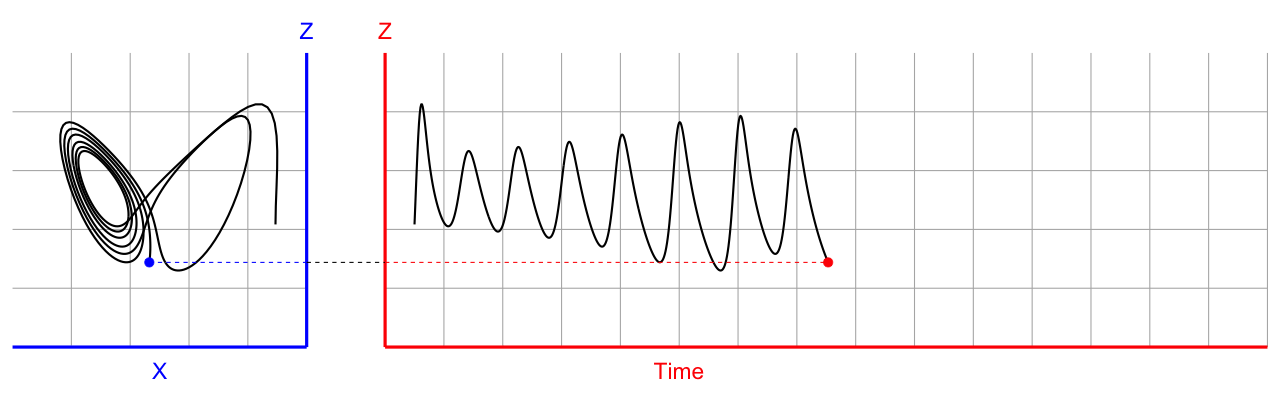

In [438]:
from IPython import display
display.Image("./image2.gif")

## Sequential Auto-Encoder Model
There are a few major components to the sequential auto-encoder model shown below.
- Encoder: Transforms spiking activity into a set of initial conditions (g0) of a dynamical system
- Decoder/Generator: Simulates the development of a dynamical system over time g(t).
- Latent projection (W1): A low-dimensional projection of the latent state s(t).
- Readout (W2): Projecting back to the full neural state to produce firing rates r(t) that best match the spiking activity n(t).

The goal of this model is to make the n(t) at the end match the input n(t) as closely as possible.

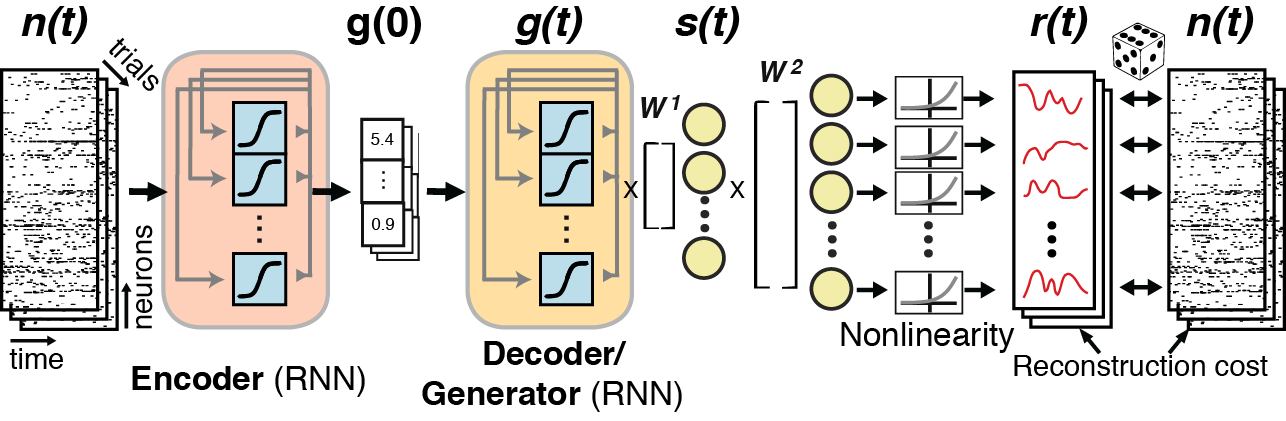

In [442]:
from IPython import display
display.Image("./LFADS_architecture.png")
#https://snel-repo.github.io/autolfads/theory/

The Encoder and Generator will both be built using Recurrent Neural Networks (RNNs). 

First, lets build the basic structure of the SAE model

In [383]:
# Vanilla SAE code
class VanillaSAE(torch.nn.Module):
    def __init__(self, 
                input_size = 107, 
                latent_size = 64, 
                encoder_size = 64, 
                out_size = 142, 
                cell_encoder = None,
                cell_gen = None, 
                fwd_steps = 10, 
                low_D_size = 10):
        super().__init__()
        #---------------Student's work------------------------------------------
        self.encoder = "TODO"
        self.ic_linear = "TODO"
        self.fwd_steps = "TODO"
        self.decoder = "TODO"
        self.latents_proj = "TODO"
        self.readout = "TODO"
        #----------------------------------------------------------------------
  
    def forward(self, x):
        # Implement forward pass of AE network
        #---------------Student's work------------------------------------------
        
        #----------------------------------------------------------------------
        return rates, latents

## Types of RNNs
There are few different types of RNNs. All follow the same basic set of operations.

There are three main operations that all RNNs perform.

1. They regulate how inputs affect the hidden state
2. They regulate how the hidden state affects itself
3. They regulate how the hidden state affects the output

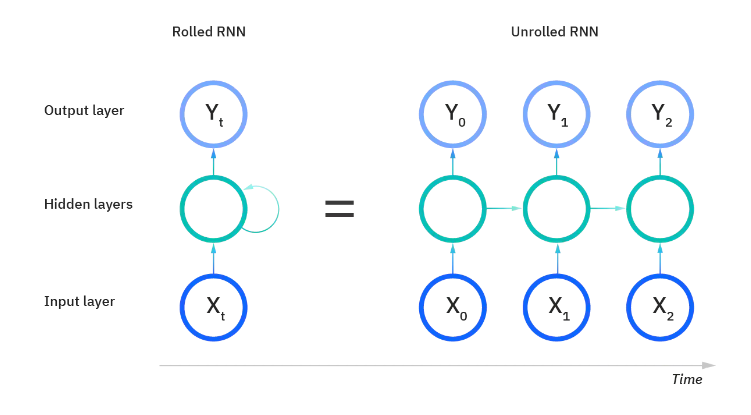

In [443]:
from IPython import display
display.Image("./RNNs.png")
#https://www.ibm.com/cloud/learn/recurrent-neural-networks

I have provided an abstract RNN class that can be used for both the encoders and the generator.

You need to fill out the code so that the RNN
- uses inputs to update the hidden state

and

- logs the hidden state for each time step

The cell should return states, hidden, where states is the full state for each time point, and hidden is the final hidden state after running over the whole input sequence.

### Abstract RNN

In [286]:
loss_function = F.poisson_nll_loss
class AbstractRNN(nn.Module):
  def __init__(self, cell, bidirectional = False):
    super().__init__()
    self.cell = cell
    self.encoders = bidirectional

  def forward(self, input, h_0 = None):
    hidden = h_0
    n_batch, n_time, _ = input.shape
    if not self.encoders:
    #---------------------Student's Work--------------------------------------------
      
    #---------------------------------------------------------------------------
      return states, hidden
    else:
      hidden =  torch.zeros(n_batch, self.cell.hidden_size)
      for input_step in input.transpose(0,1):
        hidden = self.cell(input_step, hidden)
        
      hidden_rev = torch.zeros(n_batch, self.cell.hidden_size)
      for input_step in reversed(input.transpose(0,1)):
        hidden_rev = self.cell(input_step, hidden_rev)

      hidden_enc = torch.stack((hidden, hidden_rev))
      return _, hidden_enc

### Linear RNN Cell
Now you should fill out the linear RNN. This model has only linear weights governing the state update and input weights.

Mathematically:

hidden(t+1) = whh * hidden(t) + wih * hidden(t)

This can be accomplished with a single nn.Linear layer

In [247]:
class LinearRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    #---------------Student's work------------------------------------------
    self.input_size = "TODO"
    self.hidden_size = "TODO"
    self.in2hidden = "TODO"
    #-----------------------------------------------------------------------
  def forward(self, input, hidden):
     #---------------Student's work------------------------------------------

    #-----------------------------------------------------------------------
    return hidden


### Nonlinear RNN Cell

In [248]:
class NonLinearRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    #---------------Student's work------------------------------------------
    self.input_size = "TODO"
    self.hidden_size = "TODO"
    self.in2hidden = "TODO"
    #-----------------------------------------------------------------------

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    #---------------Student's work------------------------------------------
    
    #-----------------------------------------------------------------------
    return hidden

### Gated Recurrent Unit Cell
GRUs are a more complex RNN that have methods to stop the RNN from "forgetting" things that happened a long time ago.

Complete the GRU cell. You should only need two nn.Linear networks in the model's __init__ function.

In [288]:
class GRUTemp(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(GRUTemp, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    #---------------Student's work------------------------------------------
    self.in2hidden = "TODO"
    self.hidden2hidden = "TODO"
    #-----------------------------------------------------------------------
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / np.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, input, hidden=None):
    if hidden is None:
        hidden = Variable(input.new_zeros(input.size(0), self.hidden_size))
    #---------------Student's work------------------------------------------
    
    #-----------------------------------------------------------------------
    return h_out

## Sequential Auto-Encoder Testing
Now that you've built each cell, it's time to train your first sequential auto-encoder!

First, you'll have to do a bit more coding to write the training loop.

In [446]:
lin_sae = VanillaSAE(
    input_size = 107, 
    latent_size = 128,
    encoder_size = 64,
    cell_encoder = GRUTemp,
    cell_gen = LinearRNN,
    fwd_steps = 10, 
    low_D_size = 10)

nl_sae = VanillaSAE(
    input_size = 107, 
    latent_size = 128,
    encoder_size = 64,
    cell_encoder = GRUTemp,
    cell_gen = NonLinearRNN,
    fwd_steps = 10, 
    low_D_size = 10)

gru_sae = VanillaSAE(
    input_size = 107, 
    latent_size = 128,
    encoder_size = 64,
    cell_encoder = GRUTemp,
    cell_gen = GRUTemp,
    fwd_steps = 10, 
    low_D_size = 10)
    
sae_list = [ gru_sae]
sae_labels = ["GRU"]

# Build your training loop
epochs = 200
outputs = []
losses = np.zeros((epochs, len(sae_list)))
for i, sae in enumerate(sae_list):
  print(f"Working on model: {sae_labels[i]}")
  optimizer = torch.optim.Adam(sae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)
  for epoch in range(epochs):
    if np.mod(epoch, 10)==0:
      print("Epoch: {}".format(epoch))
    for (data_batch, data_recon, vel) in dl_tensor_train:

      #------------------For Students------------------------
      # Output of Autoencoder
      rates, latents = "TODO"
      
      # Calculating the loss function
      loss = loss_function(rates, data_recon, log_input=False)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #-----------------------------------------------------

      # Storing the losses in a list for plotting
      losses[epoch, i] = loss.detach().numpy()
    # outputs.append((epochs, data_batch, reconstructed))



Working on model: GRU
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190


(0.23, 0.27)

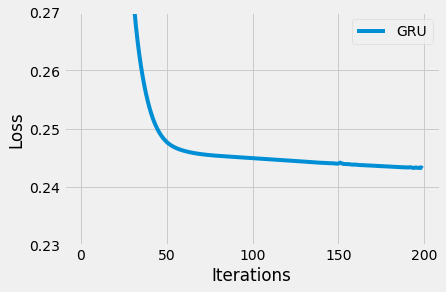

In [448]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
for i in range(len(sae_list)):
  plt.plot(losses[:,i], label = sae_labels[i])
plt.legend()
plt.ylim((0.23, 0.27))

## SAE Latent Trajectories

torch.Size([75, 35, 107])
(75, 45, 3)
[0.90368533]


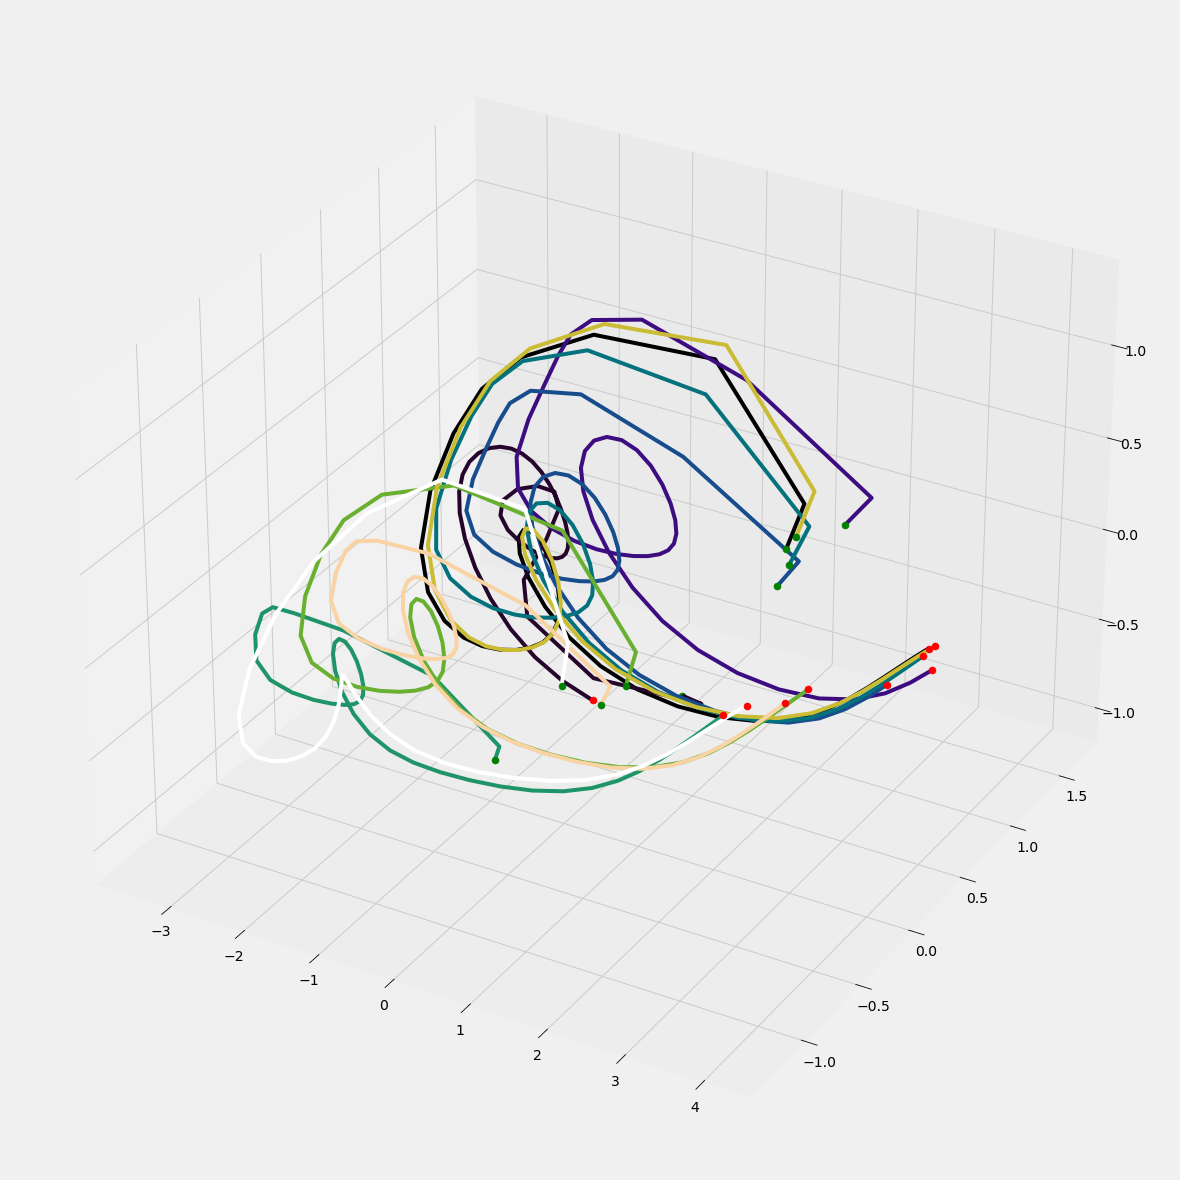

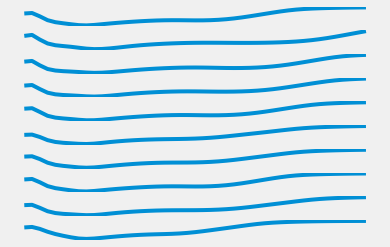

In [467]:
num_trials = 10
cmap = cmr.rainforest
colors = cmap(np.linspace(0, 1, num_trials))
latents = []
fig2 = plt.figure(figsize=(20,20))
fig3 = plt.figure()
num_models = len(sae_list)
explained_variance = np.zeros(num_models)
for i, sae in enumerate(sae_list):
  ax2 = fig2.add_subplot(num_models, 1, i+1, projection="3d")
  print(ds_tensor_train[0].shape)
  ac1 = np.zeros(num_trials)
  pred_rates, latents_all = sae(ds_tensor_train[0])
  latents_all = latents_all.detach().numpy()
  n_trials, n_steps, n_latents = latents_all.shape
  latents_flat = latents_all.reshape(-1, n_latents)
  pca = PCA(n_components=3)
  latents = pca.fit_transform(latents_flat)
  latents = latents.reshape(n_trials, n_steps, 3)
  explained_variance[i] = np.sum(pca.explained_variance_ratio_)

  t = np.linspace(0, n_steps, n_steps)

  for j in range(num_trials):
    ax2.plot(latents[j,:, 0], latents[j,:,1], latents[j,:,2], color = colors[j,:])
    ax2.scatter(*latents[j,0,:], color = 'g', s = 50)
    ax2.scatter(*latents[j,-1,:], color = 'r', s = 50)
    
    ax3 = fig3.add_subplot(num_trials, num_models, num_models*i + j +1)
    ax3.plot(t, latents[j,:,0])
    ax3.axis("off")
print(latents.shape)
print(explained_variance)
pred_rates= pred_rates.detach().numpy()

## SAE vs. AE: How much does a dynamics model get us?

In [469]:

# Compare metrics for AE and SAE
vel = ds_tensor_train[2]
rates= ds_tensor_train[0]

latents_smooth = np.zeros((n_trials, n_bins, n_latents))
rates_smooth = np.zeros((n_trials, n_bins, 107))
pred_rates_smooth = np.zeros((n_trials, n_bins, 142))

kernel_size = 5


vel = ds_tensor_train[2]
vel = np.reshape(vel, (-1, 2))
pred_rates_fit = pred_rates[:, 0:35,0:107]
rates_fit = rates.reshape((-1, 107))
pred_rates_fit = pred_rates_fit.reshape((-1, 107))
pred_rates_fit = pred_rates_fit[:,:107]

regRatesX = LinearRegression().fit(rates_fit, vel[:,0])
regRatesY = LinearRegression().fit(rates_fit, vel[:,1])

regPredRatesX = LinearRegression().fit(pred_rates_fit, vel[:,0])
regPredRatesY = LinearRegression().fit(pred_rates_fit, vel[:,1])

r2rateX = regRatesX.score(rates_fit, vel[:,0])
r2rateY = regRatesY.score(rates_fit, vel[:,1])

r2SAEPredRateX = regPredRatesX.score(pred_rates_fit, vel[:,0])
r2SAEPredRateY = regPredRatesY.score(pred_rates_fit, vel[:,1])

print(f"R2 of X vel decoding from neurons: {r2rateX}")
print(f"R2 of Y vel decoding from neurons: {r2rateY}")

print(f"R2 of X vel decoding from SAE autoencoded neurons: {r2SAEPredRateX}")
print(f"R2 of Y vel decoding from SAE autoencoded neurons: {r2SAEPredRateY}")

print(f"R2 of X vel decoding from autoencoded neurons: {r2PredRateX}")
print(f"R2 of Y vel decoding from autoencoded neurons: {r2PredRateY}")

R2 of X vel decoding from neurons: 0.5078185421223698
R2 of Y vel decoding from neurons: 0.29200513121533633
R2 of X vel decoding from SAE autoencoded neurons: 0.6686802526443535
R2 of Y vel decoding from SAE autoencoded neurons: 0.519776582464056
R2 of X vel decoding from autoencoded neurons: 0.53609913163857
R2 of Y vel decoding from autoencoded neurons: 0.4399628546439066




# Part 3: Variational Auto-Encoding

## Overfitting problem

In [26]:
# Illustrate overfitting problems

## Variational auto-encoders

In [27]:
# Illustrate how variational models help

## What we need to add

### Probability distribution over initial conditions

In [28]:
# Probabilistic sampling

### Prior on IC distribution

In [29]:
# KL divergence

## Code the v-SAE Class

In [30]:
# Modify SAE to be variational
class VariationalSAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        
        self.encoder = "Make an encoder network to find initial conditions"
       
        self.decoder = "Make a decoder network to model latent dynamics"

        self.readout = "Simple linear readouts"
  
    def forward(self, x):
        # Implement forward pass of v-SAE network
        return decoded

## Train the v-SAE

## Compare v-SAE to SAE and AE

### Visualize ICs

### Compare metrics

# Part 4: Future Directions

## Interpretability

## Neural Manifolds